# Data wrangling

In this notebook, we will clean the datasets that were extracted from MIMIC-III database.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
import seaborn as sns

# for pretty printing pandas dataframes
from IPython.display import display, HTML

%matplotlib inline
plt.style.use('seaborn-notebook')

## Data collection

The datasets are stored in CSV format in the 'data' folder.

In [2]:
def get_path(filename, suffix):
    """Return the path
    
    Args: 
        filename (string): name of the file
        suffix (string): extension of the file
        
    Returns:
        path
    """
    # Join the path for "data" folder
    cwd = os.getcwd()
    dir_name = os.path.join(cwd, 'data')
    
    return os.path.join(dir_name, filename + "." + suffix)

#### Collect the feature data that are the multvariate time series
The features are stored in *chartdata*, *labdata*, and *outputdata* CSV files. First, we load the data from these three files.

In [3]:
filenames = ['chartdata',"labdata", "outputdata"]
paths = [get_path(filename, 'csv') for filename in filenames]

# Read and store data into a list
data = []
for path in paths:
    df = pd.read_csv(path, index_col=0, converters={'intime':np.datetime64}, engine='python')
    df.loc[:, 'time'] = pd.to_timedelta(df.loc[:, 'time']) # cast the dtype to timedelta
    data.append(df)

Print the info of the data.

In [4]:
# print the data types
for i, filename in enumerate(filenames):
    print("Data types in {} are: \n".format(filename), data[i].dtypes, "\n")
    print("First 5 rows of {} are:\n".format(filename), data[i].head(), "\n")

Data types in chartdata are: 
 icustay_id              int64
intime         datetime64[ns]
time          timedelta64[ns]
category               object
valuenum              float64
dtype: object 

First 5 rows of chartdata are:
    icustay_id              intime     time    category  valuenum
0      200003 2199-08-02 19:50:04 00:09:56         GCS       5.0
1      200003 2199-08-02 19:50:04 00:09:56  heart rate     119.0
2      200003 2199-08-02 19:50:04 00:09:56   resp_rate      35.0
3      200003 2199-08-02 19:50:04 00:09:56      sys_BP      91.0
4      200003 2199-08-02 19:50:04 01:09:56  heart rate     122.0 

Data types in labdata are: 
 icustay_id              int64
intime         datetime64[ns]
time          timedelta64[ns]
category               object
valuenum              float64
dtype: object 

First 5 rows of labdata are:
    icustay_id              intime              time   category  valuenum
0      200003 2199-08-02 19:50:04 -1 days +21:49:56        BUN      21.0
1      2

We concatenate these dataframes along axis=0. Also, we convert the 'time' column from timedelta type by adding the current date.

In [5]:
df = pd.concat(data)
df['time'] = df['time'] + datetime.date.today() # convert the timedelta to datetime 

# Print the dataframe
df.head()

,icustay_id,intime,time,category,valuenum
0,200003,2199-08-02 19:50:04,2017-09-29 00:09:56,GCS,5.0
1,200003,2199-08-02 19:50:04,2017-09-29 00:09:56,heart rate,119.0
2,200003,2199-08-02 19:50:04,2017-09-29 00:09:56,resp_rate,35.0
3,200003,2199-08-02 19:50:04,2017-09-29 00:09:56,sys_BP,91.0
4,200003,2199-08-02 19:50:04,2017-09-29 01:09:56,heart rate,122.0


We then pivot the table by passing columns as category such that each row shows all variables of one obervation, which is a step closer to the tidy data.

In [6]:
feature_df = df.pivot_table('valuenum', index=['icustay_id', 'time'], columns='category')
feature_df.sort_index()
feature_df.head()

category                         BUN  FIO2  GCS  HCO3  PO2   WBC  heart rate  \
icustay_id time                                                                
200003     2017-09-28 21:49:56  21.0   NaN  NaN  23.0  NaN  14.8         NaN   
           2017-09-29 00:09:56   NaN   NaN  5.0   NaN  NaN   NaN       119.0   
           2017-09-29 00:24:56   NaN   NaN  NaN   NaN  NaN   NaN         NaN   
           2017-09-29 01:09:56   NaN   NaN  NaN   NaN  NaN   NaN       122.0   
           2017-09-29 01:34:56   NaN   NaN  NaN   NaN  NaN   NaN       115.0   

category                        potassium  resp_rate  sodium  sys_BP  \
icustay_id time                                                        
200003     2017-09-28 21:49:56        3.1        NaN   140.0     NaN   
           2017-09-29 00:09:56        NaN       35.0     NaN    91.0   
           2017-09-29 00:24:56        NaN        NaN     NaN     NaN   
           2017-09-29 01:09:56        NaN       34.0     NaN    81.0   
           2017-09-29 01:34:56        NaN       33.0     NaN    98.0   

category                        temperature  urine_out  
icustay_id time                                         
200003     2017-09-28 21:49:56          NaN        NaN  
           2017-09-29 00:09:56          NaN        NaN  
           2017-09-29 00:24:56          NaN      230.0  
           2017-09-29 01:09:56         39.0        NaN  
           2017-09-29 01:34:56          NaN        NaN

#### Collect the target data including label and SAPS-II score

The label and SAPS-II score are stored in *patient_details* and *sapsii_score* files. We load the data from these two files, and then combine them together.

In [7]:
# load the patient details from file 
path = get_path('patient_details', 'csv')
patient_df = pd.read_csv(path, index_col=0)
patient_df = patient_df.set_index('icustay_id').sort_index()
patient_df.head()

,subject_id,hadm_id,gender,dbsource,age,intime,los,survival,in_hospital_dealth,height_avg,weight_avg
icustay_id,,,,,,,,,,,
200003,27513,163557,M,carevue,48.30,2199-08-02 19:50:04,19.97,75.17,0,NaN,46.4
200007,20707,129310,M,carevue,43.35,2109-02-17 10:03:37,3.24,-1.00,0,153.7,79.9
200014,9514,127229,M,carevue,84.73,2105-02-16 23:16:48,4.60,10.03,0,172.7,96.5
200019,21789,112486,F,carevue,82.88,2178-07-08 09:03:12,2.90,2.62,1,NaN,72.9
200021,61691,109307,M,metavision,60.85,2114-12-26 19:45:12,1.95,-1.00,0,NaN,63.0


In [8]:
# load the patient SAPS-II score
path = get_path('sapsii_score', 'csv')
sapsii_df = pd.read_csv(path, index_col=0)
sapsii_df = sapsii_df.set_index('icustay_id').sort_index()

# convert the probaility to labeling
sapsii_df['sapsii_prediction'] = np.where(sapsii_df['sapsii_prob']>0.5, 1, 0)
sapsii_df = sapsii_df.drop('sapsii_prob', 1)
sapsii_df.head()

,sapsii_prediction
icustay_id,
200003,0
200007,0
200014,0
200019,1
200021,0


In [9]:
# Create a dataframe
feature_index = np.sort(feature_df.index.get_level_values('icustay_id').unique().values)
target_df = pd.DataFrame(index = feature_index)
target_df.index.name = 'icustay_id'

# Merge the patient_df and sapsii_df together
target_df = pd.concat([target_df, patient_df['in_hospital_dealth'], sapsii_df], axis = 1, join_axes=[target_df.index])
target_df.head()

,in_hospital_dealth,sapsii_prediction
icustay_id,,
200003,0,0
200007,0,0
200014,0,0
200019,1,1
200021,0,0


## Data cleaning

### Dectect outliers
We first get a brief statistics of the dataframe of the feature. 

In [10]:
feature_df.describe()

category,BUN,FIO2,GCS,HCO3,PO2,WBC,heart rate,potassium,resp_rate,sodium,sys_BP,temperature,urine_out
count,61019.000000,9781.000000,195545.000000,58402.000000,71477.000000,57305.000000,727503.000000,100003.000000,725291.000000,77621.000000,678309.000000,219675.000000,355367.000000
mean,26.763787,50.414641,4.047260,23.237726,183.363753,12.365824,85.510838,4.226053,18.841348,138.187536,119.567359,36.896975,138.546588
std,22.705096,14.479749,1.268771,4.870280,118.540812,10.725286,18.618176,0.786722,5.542793,5.591240,22.951818,0.863139,949.048086
min,1.000000,0.300000,1.000000,2.000000,10.000000,0.100000,0.350000,0.600000,1.000000,1.210000,0.350000,20.900000,0.300000
25%,13.000000,40.000000,3.330000,21.000000,94.000000,7.800000,72.000000,3.700000,15.000000,136.000000,103.000000,36.390000,40.000000
50%,19.000000,50.000000,4.670000,23.000000,143.000000,10.800000,84.000000,4.100000,18.000000,138.000000,117.000000,36.890000,80.000000
75%,32.000000,60.000000,5.000000,26.000000,251.000000,14.800000,97.000000,4.600000,22.000000,141.000000,134.000000,37.440000,170.000000
max,272.000000,99.000000,6.000000,53.000000,689.000000,600.200000,222.000000,17.500000,69.000000,182.000000,323.000000,42.780000,555975.000000


Based on the statistics, some measurements are far from the distribution and could be outliers. We then use the z-score to determine the outliers.  

(-5, 5)

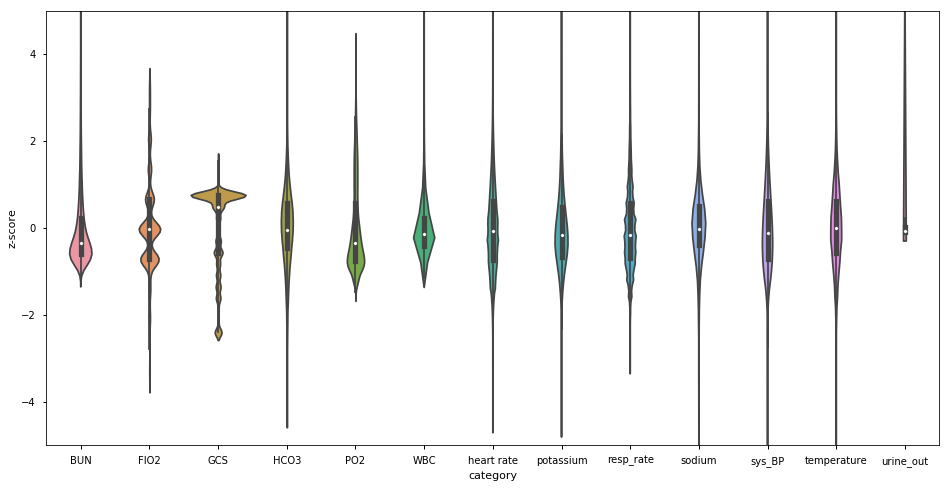

In [11]:
# Calculate the zscore of the data
zscore = (feature_df - feature_df.mean()) / feature_df.std()

# Boxplot of the zscore
boxplot_dims = (16, 8)
fig, ax = plt.subplots(figsize=boxplot_dims)
sns.violinplot(ax=ax, data=zscore)
ax.set_ylabel('z-score')
ax.set_ylim([-5,5])

We replace the data with NaN if its z-score is greater or less than 3.5 or -3.5 (GCS has range from 1 to 5, data that is out of this range is considered to be the outlier). 

In [12]:
# Conditions of outliers
for feature in (set(feature_df.columns) - set(['GCS'])):
    feature_df.loc[np.abs(zscore[feature]) > 3.5, feature] = np.nan

# Average GCS should be between the lowest (3/3=1) to highest (15/3=5)
feature_df.loc[ (feature_df['GCS'] >= 5) | (feature_df['GCS'] <= 1), 'GCS'] = np.nan

(-5, 5)

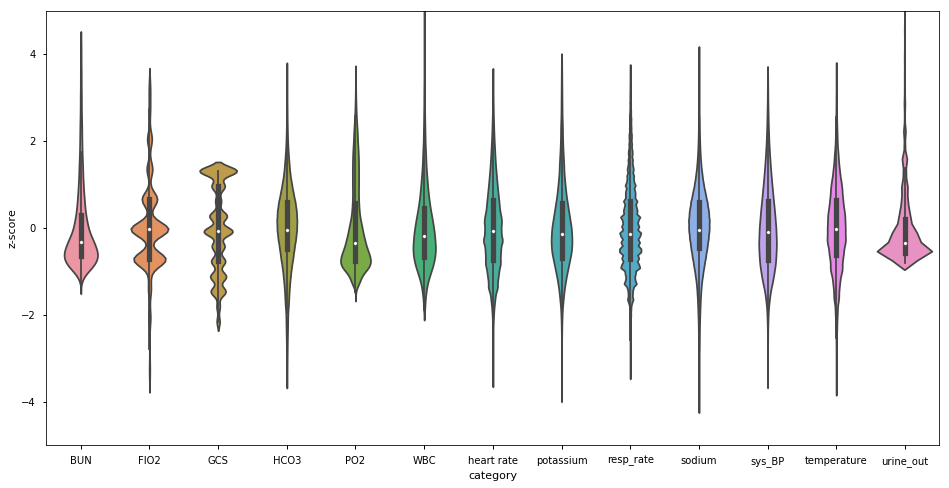

In [13]:
# Calculate the zscore of the data
zscore = (feature_df - feature_df.mean()) / feature_df.std()

# Boxplot of the zscore
boxplot_dims = (16, 8)
fig, ax = plt.subplots(figsize=boxplot_dims)
sns.violinplot(ax=ax, data=zscore)
ax.set_ylabel('z-score')
ax.set_ylim([-5,5])

### Data resampling, interpolation, and imputation

We resample the irregalur time series into regular time series with time interval of 2 hours. Then, we interpolate the time series by each patient. Finally, we imputate using the mean if the whole time series is missing.

In [14]:
from sklearn.preprocessing import Imputer, MinMaxScaler

# Resample the time index
time_index = pd.date_range(datetime.date.today(), periods=12, freq='2h', name='time')
resampled_df = feature_df.groupby(level=0).apply(lambda group:group.resample('2h', level=1).mean())

# Interpolate
resampled_df = resampled_df.groupby(level=0).apply(lambda group: group.reset_index(level=0, drop=True).reindex(time_index))
resampled_df = resampled_df.groupby(level=0).apply(lambda group: group.interpolate())
resampled_df = resampled_df.groupby(level=0).apply(lambda group: group.fillna(method='backfill'))

# Imputate using the mean if the whole time series is missing
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imputed_data = imp.fit_transform(resampled_df)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(imputed_data)

# Store the processed dataframe as processed_df
processed_feature_df = pd.DataFrame(scaled_data, index=resampled_df.index, columns=resampled_df.columns)

We plot an example of the original data and the precessed data.

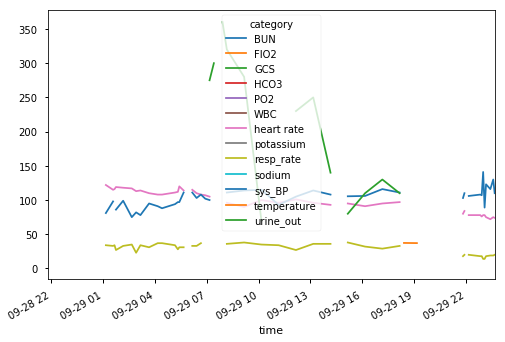

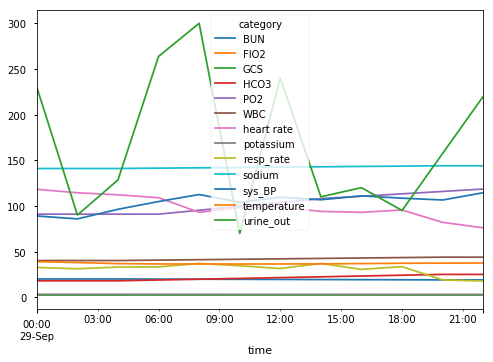

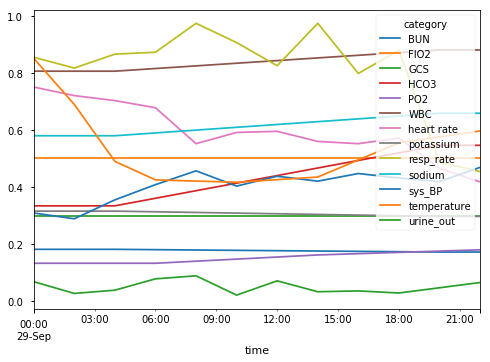

In [15]:
feature_df.loc[(200003), :].plot()
plt.figure()
resampled_df.loc[(200003), :].plot()
plt.figure()
processed_feature_df.loc[(200003), :].plot()

## Create train, valid, and test data

In [22]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Turns the data to list of data
features = []
targets = []

for icustay_id, sub_df in processed_feature_df.groupby(level=0):
    features.append(processed_feature_df.loc[icustay_id,:].values)
    targets.append(target_df.loc[icustay_id, :].values.reshape(1,2))
    
# Split the 'features' and 'target' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    targets, 
                                                    test_size = 0.15, 
                                                    random_state = 10)

# Further split the 'features' and 'target' data from training data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, 
                                                     y_train, 
                                                     test_size = 0.18, 
                                                     random_state = 10)

# Show the results of the split
print("Training set has {} samples.".format(len(X_train)))
print("Validation set has {} samples.".format(len(X_valid)))
print("Testing set has {} samples.".format(len(X_test)))

Training set has 16746 samples.
Validation set has 3676 samples.
Testing set has 3604 samples.


The feature data is a list of array, and it is better to convert the data that can be stored using csv format. Also, remove the origin ICU-stay ID and time interval.

In [23]:
# create an index contains id and time for training data
time_index = np.arange(0,12,1)
id_index = np.arange(0, len(X_train), 1)
combined_index = pd.MultiIndex.from_product([id_index, time_index], names=['id', 'time'])

# Convert the training data into dataframe
X_train = pd.DataFrame(np.concatenate(X_train, axis =0), index=combined_index, columns=processed_feature_df.columns)
y_train = pd.DataFrame(np.concatenate(y_train, axis=0), index=id_index, columns=target_df.columns)
y_train.index.name = 'id'

In [35]:
# create an index from validation data
id_index = np.arange(len(y_train), len(y_train) + len(y_valid), 1)
combined_index = pd.MultiIndex.from_product([id_index, time_index], names=['id', 'time'])

# convert the validation data into dataframe
X_valid = pd.DataFrame(np.concatenate(X_valid, axis=0), index=combined_index, columns=processed_feature_df.columns)
y_valid = pd.DataFrame(np.concatenate(y_valid, axis=0), index=id_index, columns=target_df.columns)
y_valid.index.name = 'id'

In [36]:
# create an index from testing data
id_index = np.arange(len(y_train) + len(y_valid), len(y_train) + len(y_valid)+ len(y_test), 1)
combined_index = pd.MultiIndex.from_product([id_index, time_index], names=['id', 'time'])

# convert the validation data into dataframe
X_test = pd.DataFrame(np.concatenate(X_test, axis=0), index=combined_index, columns=processed_feature_df.columns)
y_test = pd.DataFrame(np.concatenate(y_test, axis=0), index=id_index, columns=target_df.columns)
y_test.index.name = 'id'

In [37]:
for filename, data in zip(['X_train', 'X_valid', 'X_test', 'y_train', 'y_valid', 'y_test'], 
                          [X_train, X_valid, X_test, y_train, y_valid, y_test]):
    data.to_csv(get_path(filename, 'csv'))